In [100]:
import os
import time
import copy
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler

import torchvision
from torchvision import datasets, models, transforms

data_path = '../../datasets/crack-detection'

print(f'Classes in dataset directory: {os.listdir(data_path)}')

Classes in dataset directory: ['Negative', 'Positive']


In [101]:
negative_count = len(os.listdir(data_path + '/Negative/'))
positive_count = len(os.listdir(data_path + '/Positive/'))

print(f'There are {negative_count} negative and {positive_count} positive samples.')

There are 20000 negative and 20000 positive samples.


In [102]:
image_folder = datasets.ImageFolder(data_path)
len(image_folder)

train_size = int(0.5 * len(image_folder))
valid_size = int(0.3 * len(image_folder))
test_size  = len(image_folder) - (train_size + valid_size)

train_ds, valid_ds, test_ds = torch.utils.data.random_split(image_folder, [train_size, valid_size, test_size])

print(f'There are {len(train_ds)} train., {len(valid_ds)} valid. and {len(test_ds)} test samples.')

There are 20000 train., 12000 valid. and 8000 test samples.


In [103]:
 
train_ds.dataset.transform = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

valid_ds.dataset.transform =  transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

test_ds.dataset.transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

In [104]:
train_dataloader = torch.utils.data.DataLoader(train_ds, batch_size=4, shuffle=True)
valid_dataloader = torch.utils.data.DataLoader(valid_ds, batch_size=4, shuffle=False)
test_dataloader  = torch.utils.data.DataLoader(test_ds,  batch_size=4, shuffle=False)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cpu


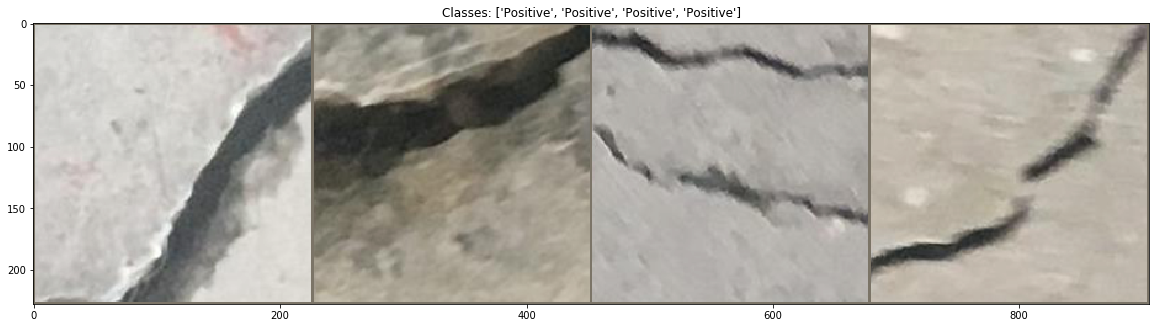

In [105]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.figure(figsize=(20, 6))
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated

# image_folder.classes
# Get a batch of training data
inputs, classes = next(iter(train_dataloader))
out = torchvision.utils.make_grid(inputs)

imshow(out, title=f'Classes: {[train_ds.dataset.classes[x] for x in classes]}')

In [106]:
dataloaders = {
    'train': train_dataloader,
    'valid': valid_dataloader
}

dataset_sizes = {
    'train': len(train_ds),
    'valid': len(valid_ds)
}

def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print(f'Epoch {epoch+1} out of {num_epochs}')

        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()
            else:
                model.eval()

            running_loss = 0.0
            running_corrects = 0.0

            # Iterate over data
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # Zero parameter gradients
                optimizer.zero_grad()

                # Forward
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # Backward + optimize, only for training
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # Statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]
            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    model.load_state_dict(best_model_wts)
    return model

In [107]:
model_finetune = models.resnet18(pretrained=True)

num_features = model_finetune.fc.in_features
model_finetune.fc = nn.Linear(num_features, 2)

model_finetune = model_finetune.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model_finetune.parameters(), lr=0.001, momentum=0.9)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1);

In [99]:
model_finetune = train_model(
    model_finetune,
    criterion,
    optimizer,
    exp_lr_scheduler,
    num_epochs=25
)

Epoch 1 out of 25


UnboundLocalError: local variable 'inputs' referenced before assignment